In [5]:
## import os
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pandas as pd
import pickle

In [21]:
cd /global/u1/j/janewman/uniformity/

/global/u1/j/janewman/uniformity


In [22]:
# Load Jeff's results

i_lim [24.05       24.42628749 24.64640157 24.80257499 24.92371251 25.02268906
 25.10637255 25.17886248 25.24280314 25.3       ]
{1: 25.15, 2: 25.526287494579975, 3: 25.746401568399577, 4: 25.90257498915995, 5: 26.023712505420022, 6: 26.122689062979553, 7: 26.206372550017818, 8: 26.27886248373993, 9: 26.342803136799155, 10: 26.4}


In [23]:


# array of the years used (corresponding to first axis of the results arrays)

years = pickle.load(open('years.pkl', "rb"))

# array of the bands used (corresponding to second axis)

bands = pickle.load(open('bands.pkl', "rb"))

# array of the minz of each redshift bin  (corresponding to third axis)

minzs = pickle.load(open('minzs.pkl', "rb"))

# array of the maxz of each redshift bin  (corresponding to third axis)

maxzs = pickle.load(open('maxzs.pkl', "rb"))

# array of the derivative of <z> with respect to m5, for each combination
#    of year, band, and bin number
# i.e. axes are ((nyears,nbands,nbins))

meanzderiv = pickle.load(open('meanzderiv.pkl', "rb"))

# array of the logatiyhmic derivative of n with respect to m5
# (i.e., 1/n * dn/dm5), for each combination
#    of year, band, and bin number
# i.e. axes are ((nyears,nbands,nbins))

densityderiv = pickle.load(open('densityderiv.pkl', "rb"))

In [3]:
cd /global/homes/b/bleis89/rubin_roman_sims

/global/u1/b/bleis89/rubin_roman_sims


1 (6, 1, 1, 249)


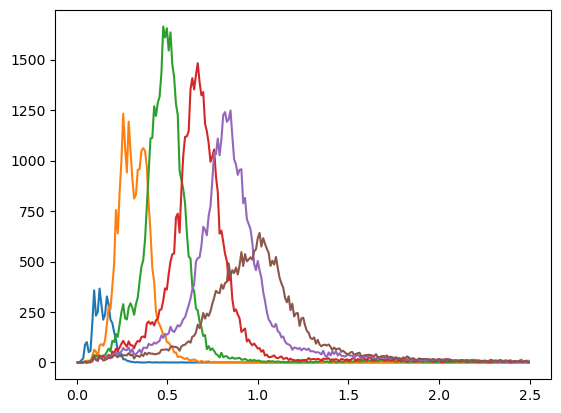

In [6]:
# I also re-ran Jeff's simulation_calcs notebook in order to save redshift distributions (in the directory below)
# I didn't bother recalculating the derivatives, since I didn't change anything, but this should be trivial
zbins = np.linspace(0, 2.5, 250) # hardcoded

# xample
year = 1
outzfile = 'nofzy'+str(year)+'.pkl'
n_of_zs = pickle.load(open(outzfile, "rb"))
print(year, n_of_zs.shape)
plt.plot((zbins[1:]+zbins[:-1])/2, n_of_zs[:, 0, 0, :].T)

1 (6, 1, 1, 249)
2 (6, 1, 1, 249)
3 (6, 1, 1, 249)
4 (6, 1, 1, 249)
5 (6, 1, 1, 249)
6 (6, 1, 1, 249)
7 (6, 1, 1, 249)
8 (6, 1, 1, 249)
9 (6, 1, 1, 249)
10 (6, 1, 1, 249)


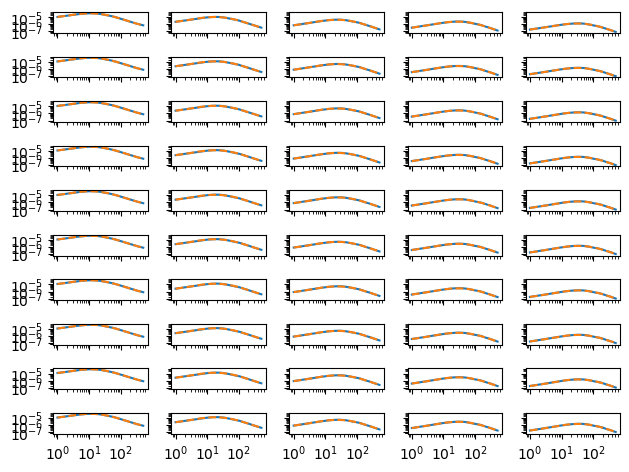

In [72]:
# compute theory Cells, assuming bias of unity, and simple fiducial cosmology.
# a 5th order polynomial is more than enough to fit the Cls in log log space well.
# need to calculate the limits for which the angular power spectra need to be integrated (down to k=0.05).
# this is stored in an lmax array. Redshift is assumed to be that of the peak of the N(z), which should be reasonably good for now.

import pyccl as ccl

deg = 5
ells = np.arange(512)
cosmo = ccl.Cosmology(Omega_c=0.25, Omega_b=0.05,
                      h=0.7, n_s=0.95, sigma8=0.8,
                      transfer_function='boltzmann_camb')

years = range(1, 11)

poly_coefs = np.zeros((deg+1, 5, len(years)))
zmeans = np.zeros((5, len(years)))
lmaxs = np.zeros((5, len(years)), dtype=np.int)

fig, axs = plt.subplots(len(years), 5, sharex=True, sharey=True)
for iy, year in enumerate(years):
    
    outzfile = 'nofzy'+str(year)+'.pkl'
    n_of_zs = pickle.load(open(outzfile, "rb"))
    print(year, n_of_zs.shape)
    
    
    for it in range(5):         ############# OFFSET below to skip first redshift bin
        gals = ccl.NumberCountsTracer(
            cosmo, has_rsd=False, 
            dndz=((zbins[1:]+zbins[:-1])/2, n_of_zs[it+1, 0, 0, :]),
            bias=(zbins[1:], np.ones_like(zbins[1:]))
        )
        zmeans[it, iy] = np.average((zbins[1:]+zbins[:-1])/2, weights=n_of_zs[it+1, 0, 0, :])
        chi = ccl.comoving_radial_distance(cosmo, a=1/(1+zmeans[it, iy]))
        
        lmaxs[it, iy] = int(0.05 * chi)
        
        cls = ccl.angular_cl(cosmo, gals, gals, ells, p_of_k_a='delta_matter:delta_matter')
        #all_cls.append(cls)
        
        z = np.polyfit(np.log(ells[1:]), np.log(cls[1:]), deg, w=1/np.log(1+ells[1:]))
        p = np.poly1d(z)
        poly_coefs[:, it, iy] = z
        
        axs[iy, it].plot(ells[1:], cls[1:])
        axs[iy, it].plot(ells[1:], np.exp(p(np.log(ells[1:]))), ls='--')
        axs[iy, it].set_yscale('log')
        axs[iy, it].set_xscale('log')

fig.tight_layout()


In [73]:
# Now needs to put everything in a gian nested dictionary! to be copied or exported somewhere else, as needed.
print("density_tomography_model = {")
for iy, year in enumerate(years):
    print("    'year"+str(year)+"': {")
    print("        'sigma8square_model': 0.8**2.0,")
    print("        'poly1d_coefs_loglog': np."+repr(poly_coefs[:, :, iy].T)+',')
    print("        'lmax': np."+repr(lmaxs[:, iy])+',')    
    print("        'dlogN_dm5': [")
    for it in range(5):    
        lsst_filters = ["u", "g", "r", "i", "z", "y"]
        res = {'cst': 0.0}
        for i, b in enumerate(bands):
            res[b] = densityderiv[iy, it, it]
        print("        "+repr(res)+',')
    print("        ],")
    print("    },")
print("}")
        

density_tomography_model = {
    'year1': {
        'sigma8square_model': 0.8**2.0,
        'poly1d_coefs_loglog': np.array([[-7.94546823e-04,  2.62494452e-02, -2.27597655e-01,
         4.67266497e-01,  3.38850627e-01, -1.14120412e+01],
       [ 3.98978657e-04,  6.69012313e-03, -1.35005872e-01,
         3.72800783e-01,  3.97123211e-01, -1.29908869e+01],
       [ 1.03940293e-03, -5.18759967e-03, -6.85178825e-02,
         2.69468206e-01,  4.60031701e-01, -1.41217016e+01],
       [ 1.42986845e-03, -1.27862974e-02, -2.26263084e-02,
         1.85536763e-01,  5.12886349e-01, -1.48861030e+01],
       [ 1.73667255e-03, -1.89601890e-02,  1.80214246e-02,
         9.50637447e-02,  5.58980246e-01, -1.55053201e+01]]),
        'lmax': np.array([ 64,  94, 124, 146, 164]),
        'dlogN_dm5': [
        {'cst': 0.0, 'u': 0.043962974958662145, 'g': 0.043962974958662145, 'r': 0.043962974958662145, 'i': 0.043962974958662145, 'z': 0.043962974958662145, 'y': 0.043962974958662145, 'ugrizy': 0.04396297495866